2D propagation of a cylindrical wave is given by:

$$
U_o\left(x_o\right)=\frac{i \pi}{\lambda} \int_{-\infty}^{\infty} U_s\left(x_s\right) \frac{z}{r_{o s}} H_1^{(1)}\left(k r_{o s}\right) \mathrm{d} x_s,
$$

The amplitude of $ H_1^{(1)} $ (a Hankel function of the first kind) can be approximated by $ \sqrt{\frac{2}{\pi k r}} $ (see https://dlmf.nist.gov/10.2#E5). 

If $U_s\left(x_s\right)$ is a point source, we can use a Dirac Delta function to solve for $U_o\left(x_o\right)$, (since integral of Dirac Delta function is 1), and after some algebra we can find the intensity of the wavefront as: 

$$
I = |U_o\left(z, r\right)|^{2} = \frac{z^{2}}{\lambda r^{3}}
$$

altenatively, $\cos(\theta) = \frac{z}{r}$, thus:

$$
I = |U_o\left(\theta, r\right)|^{2} = \frac{\cos(\theta)^{2}}{\lambda r}
$$


where r is some euclidean distance to a point, and z is the perpendicular distance to the plane of that point.

The first note to make about this point source function is that, there should be no backwards propagation. So all of the power of the wavefront should be contained within the half cylinder (cylinder because we are in a 2D plane) that propagates from the "point source" forward. Therefore, if we propagate this wave forward, and know that we had a power of "1" (arbitrary units) at the source, we should measure a power of 1 if we integrate the power density on the surface of the semi circle some distance away. Let's first test this hypothesis. 

Knowing this, we should then try and figure out what "power" needs to be applied to each ray, so that we can propagate many rays leaving the point source, and add them together on the screen to obtain the same intensity. I will for now forget about Marco Mout's thesis, as his method I just cannot understand fully, only partially, and thus it is hard to get to work. His method does however have a great advantage if I can get it to work: the computation does not need to be stopped as far as I understand every time an aperture is reached and diffraction is caused, rays can continue to propagate without stopping to know what the intensity at the aperture should have been, since each ray locally knows it's amplitude, and can carry that forward independently. This is possible because in his description, rays propagate a little infinitesimal area of the wavefront, although knowing what that infinitesimal area should be for different wavefront shapes is non-trivial. 

Anyway, for the power calculation, if the power of a wavefront is given $ P = \int{I dl}$, where I is again intensity, and $dl$ is a little line element on a surface of the wavefront, then if we have a circular wavefront, $dl = r \times d \theta$. Thus, after integration, the power of the wavefront is: 

$P = \frac{\pi}{2\lambda}$. A weird result, but if we choose $\lambda$ = \frac{2}{\pi}$ then we will have a power of 1. I don't quite understand this result but whatever. It works for us for now. 

Let's try and plot this point source propagation on a 2D grid, and check that power is conserved. Then we will try and approximate the result with rays later. 



In [1]:
import scipy.integrate
import matplotlib.pyplot as plt
import numpy as np

from diffractio import um, mm, np
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
import cupy as cp
import cupyx as cpx
%matplotlib ipympl

In [2]:
def diffractio_rs_aperture_1D(x0, 
                           z_prop,
                           aperture_width, 
                           wavelength,
                           draw_inputs=False):

    # Make scalar source
    u0 = Scalar_source_X(x0, wavelength)
    u0.plane_wave(z0=0)

    # Make scalar diffraction mask
    t0=Scalar_mask_X(x0, wavelength)
    t0.slit(x0=0, size=aperture_width*um)

    u1=t0*u0
    z = z_prop
    u2 = u1.RS(z=z, new_field=True)

    if draw_inputs:
        u0.draw()
        t0.draw()

    return u2

mempool = cp.get_default_memory_pool()

with cp.cuda.Device(0):
    mempool.set_limit(size=10*1024**3)

def monte_carlo_diffraction_cupy_1D(N_total, 
                                    final_image_real,
                                    final_image_imag,
                                    source_width_x,
                                    source_width_y,
                                    slit_radius_x,
                                    slit_radius_y,
                                    det_yx,
                                    z_prop,
                                    wavelength,
                                    batch_size=int(1e7)):  # Batch size of rays to GPU
    y_det = det_yx.shape[1]
    x_det = det_yx.shape[2]

    pdf = 1 / (source_width_x * source_width_y)
    # Initialize arrays to count the number of rays per pixel
    counts = cp.zeros((y_det, x_det), dtype=cp.int32)
    for start_idx in range(0, N_total, batch_size):
        end_idx = min(start_idx + batch_size, N_total)
        current_batch_size = end_idx - start_idx

        # Get random pixel samples of the source (or aperture) and the detector
        source_x = cp.random.uniform(-source_width_x/2, source_width_x/2, size=current_batch_size)
        source_y = cp.random.uniform(0., 0., size=current_batch_size)
        source_z = cp.zeros(current_batch_size)
        
        aperture_mask = (np.abs(source_x) < slit_radius_x)
        U = (aperture_mask).astype(cp.int32) / pdf

        # rand_theta = np.random.uniform(0, np.pi, N_aperture)
        rand_det_idx_x = cp.random.randint(x_det, size=current_batch_size)
        rand_det_idx_y = cp.random.randint(y_det, size=current_batch_size)
        
        cp.add.at(counts, (rand_det_idx_y, rand_det_idx_x), 1)

        det_x = det_yx[1, rand_det_idx_y, rand_det_idx_x]
        det_y = det_yx[0, rand_det_idx_y, rand_det_idx_x]
        det_z = cp.ones(current_batch_size) * z_prop

        # Convert coordinates to a vector for convenience
        ray_source_coord = cp.array([source_z, source_y, source_x])   
        ray_det_coord = cp.array([det_z, det_y, det_x])
        
        # Create ray vector and get magnitude and direction
        ray = ray_det_coord - ray_source_coord
        ray_magnitude = cp.linalg.norm(ray, axis = 0)

        k = 2 * np.pi / wavelength
        complex_rays = (1j * k * z_prop / (2 * ray_magnitude)) * np.sqrt(2 / (np.pi * k * ray_magnitude)) * np.exp(1j * (k * ray_magnitude - np.pi / 4)) * U

        # Add complex wavefront to each pixel in the image
        cpx.scatter_add(final_image_real, (rand_det_idx_y, rand_det_idx_x), complex_rays.real)
        cpx.scatter_add(final_image_imag, (rand_det_idx_y, rand_det_idx_x), complex_rays.imag)
        
    final_image = (final_image_real + 1j * final_image_imag)
    
    non_zero_counts = counts > 0
    final_image[non_zero_counts] *= source_width_x / counts[non_zero_counts]
    
    # Include final factors which scale image by pixel size, and have an extra term from the rayleigh sommerfeld integral. 
    return final_image

In [3]:

# Set up coordinates
x_extent = 250
z_prop = 10000
x = np.linspace(-x_extent, x_extent, 1000)
z = np.linspace(0, z_prop, 1000)
xx, zz = np.meshgrid(x, z)
r = np.sqrt(xx**2 + zz**2)

# Calculate wavelength to give us "1" at the source
P = 1 #watt
wavelength = 1.0
k = (2 * np.pi / wavelength)

U_Det = (0.5j * k * zz / r) *  np.sqrt(2 / (np.pi * k * r))

# Choose circle radius to check power density calculation
r_circ = 400

theta_indices, dtheta = np.linspace(0, -np.pi, 1000, retstep=True)
xx_indices = x_extent + r_circ * np.cos(theta_indices)
zz_indices = r_circ * -np.sin(theta_indices)
r_indices = np.sqrt(xx_indices**2 + zz_indices**2)

U_Circ = (0.5j * k * np.cos(theta_indices)) *  np.sqrt(2 / (np.pi * k * r_circ))
I_Circ = np.abs(U_Circ) ** 2

Circular_Power = scipy.integrate.simpson(y=I_Circ, x=np.abs(theta_indices)) * r_circ

Text(0, 0.5, 'Intensity')

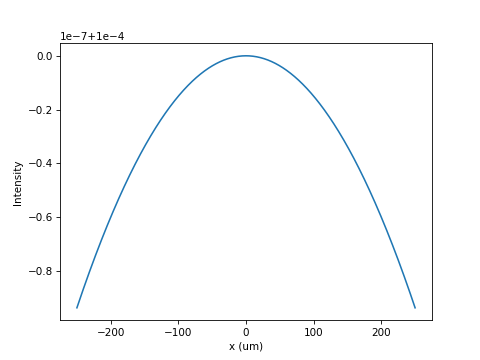

In [4]:
plt.figure()
plt.plot(x, np.abs(U_Det[-1, :]) ** 2)
plt.xlabel('x (um)')
plt.ylabel('Intensity')

The figure above is the intensity recorded on a detector 1000 um away from the point source. We should be able to use this to work what we need to do to each ray so that it has the correct amplitude to give us this intensity. 

1.570796326794794


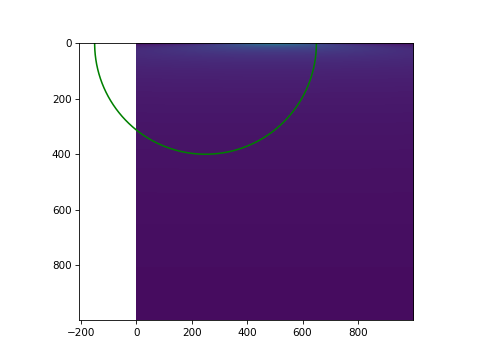

In [5]:
plt.figure()
plt.imshow((np.abs(U_Det)))
plt.plot(xx_indices, zz_indices, '-g')

print(Circular_Power)

This figure just shows the point source amplitude, and the semi-cylinder that we use to find out if we have a power of 1 when we integrate this cylinder. This is the case. 

Now how can we replicate the intensity of the figure above using a monte carlo ray tracing implementation of this point source? The naive method might be the best first port of call - what if we say that we have N rays leaving the point source, and each one carries with it an amplitude of $\sqrt(1 / N)$. How can we then add all of these rays together in a pixel to get the intensity recored above?. We should concentrate first on trying to recreate a single value in the centre of the plot first of all. So therefore we need to calculate how many rays will go through the pixel directly in front, so we can supply each with the appropriate amplitude.  

In [6]:
aperture_diameter = 50 * um
detector_width_x = 500 * um
detector_width_y = 0 * um

num_px_det_x = 1000
num_px_det_y  = 1

detector_px_width_x = detector_width_x / num_px_det_x 
detector_px_width_y = detector_width_y / num_px_det_y

num_pixels = int(num_px_det_x*num_px_det_y)
det_yx_indices = np.indices((num_px_det_y, num_px_det_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_yx_coords = det_yx_coords.T.reshape(2, num_px_det_y, num_px_det_x)

z_prop = 500 * um
wavelength = 1 * um

Good result: factor 2.23


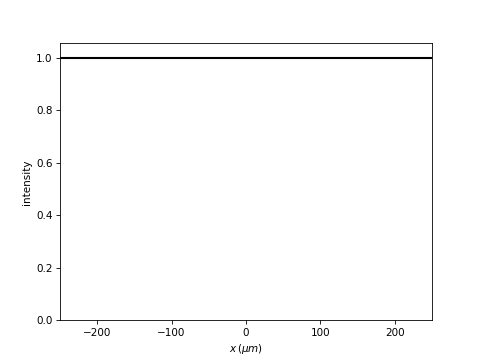

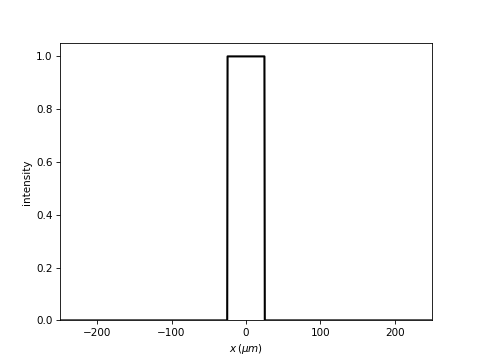

In [7]:
u2 = diffractio_rs_aperture_1D(x0=det_yx_coords[1, 0, :], 
                                z_prop=z_prop, 
                                wavelength=wavelength,
                                aperture_width=aperture_diameter, 
                                draw_inputs=True)

In [8]:
num_rays=int(1e9)

source_width_x = detector_width_x
source_width_y = 0.0
# source_y_coords = np.zeros(num_rays)
# source_x_coords = np.random.uniform(-detector_width_x/2, detector_width_x/2, num_rays)
# source_yx_coords = np.array([source_y_coords, source_x_coords])

# Assuming sample_yx_coords and det_yx_coords are defined elsewhere and are numpy arrays, convert them:
# source_yx_coords = cp.asarray(source_yx_coords)
det_yx_coords = cp.asarray(det_yx_coords)

# Initialize final image and aperture phase shifts arrays on GPU
final_image_real = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)
final_image_imag = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)

final_image = monte_carlo_diffraction_cupy_1D(num_rays, 
                                                final_image_real,
                                                final_image_imag,
                                                source_width_x,
                                                source_width_y,
                                                slit_radius_x=aperture_diameter/2,
                                                slit_radius_y=0,
                                                det_yx=det_yx_coords,
                                                z_prop=z_prop,
                                                wavelength=wavelength,
                                                batch_size=int(1e7),
                                                )

det_yx_coords = cp.asnumpy(det_yx_coords)
final_image = cp.asnumpy(final_image)

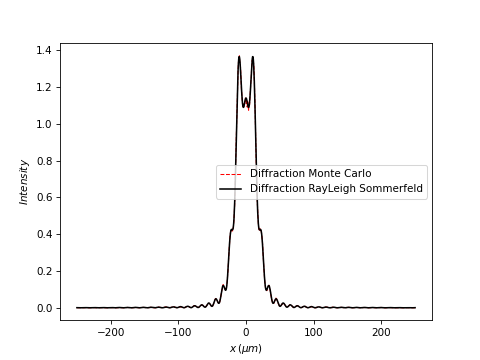

In [9]:
fig, ax = plt.subplots()

ax.set_xlabel('$x\,(\mu m)$')
ax.set_ylabel('$Intensity$')
# ax.set_xlim(left=det_yx_coords[1, 0, 0], right=det_yx_coords[1, 0, -1])
# ax.set_ylim(bottom=0)
ax.plot(det_yx_coords[1, 0, :], np.abs(final_image[0, :]) ** 2, '--r', label='Diffraction Monte Carlo', linewidth = 1)
ax.plot(det_yx_coords[1, 0, :], np.abs(u2.u) ** 2 , '-k', label='Diffraction RayLeigh Sommerfeld')
plt.legend()

/tmp/ipykernel_2761682/4084105529.py:17: DeprecationWarning: You are passing x=[0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9992e+03 1.9996e+03 2.0000e+03] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  integral = simpson(integrand_values, s_values)


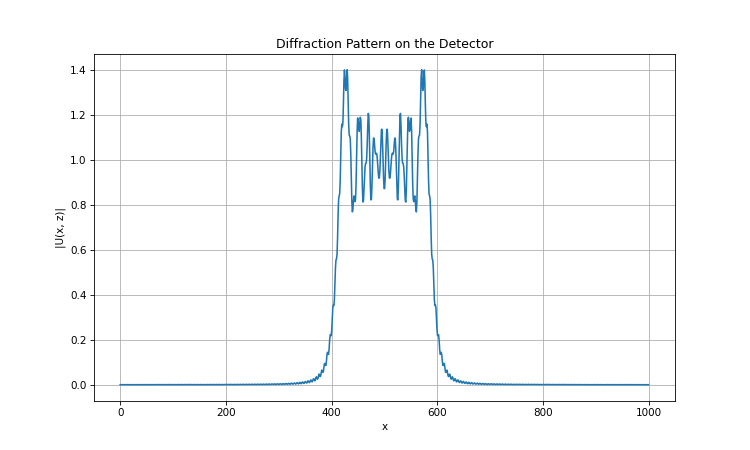

In [10]:
import numpy as np
from scipy.special import hankel1
from scipy.integrate import simpson
import matplotlib.pyplot as plt

def U(x, z, s_values, U_values, k):
    # Define the integrand function
    def integrand(s, U_s0, x, z, k):
        r = np.sqrt((x - s)**2 + z**2)
        h = (1j * k * z / (2 * r)) * np.sqrt(2 / (np.pi * k * r)) * np.exp(1j * (k * r - np.pi / 4))
        return U_s0 * h
    
    # Compute the integrand at each point s
    integrand_values = integrand(s_values, U_values, x, z, k)
    
    # Use scipy's Simpson's rule to integrate
    integral = simpson(integrand_values, s_values)
    
    return integral

# Define the parameters
z = 1000  # Propagation distance
wavelength = 1.0  # Wavelength of the wave
k = 2 * np.pi / wavelength  # Wavenumber

# Define the aperture interval and field U(s, 0) for a square wave
max_width = 2000
square_wave_width = 200
amplitude = 1

# Define s_values within the aperture range
s_values = np.linspace(0, max_width, 5001)  # 1001 points (1000 intervals)
U_values = np.zeros_like(s_values)
# Create square wave with specified width and amplitude
U_values[(s_values >= 400) & (s_values <= 600)] = amplitude  # Square wave between s=400 and s=600

# Define the detector range and resolution
x_min = 0
x_max = 1000
num_x_points = 1000  # Number of points on the detector
x_values = np.linspace(x_min, x_max, num_x_points)

# Calculate U(x, z) for all x points on the detector
U_xz_values = np.array([U(x, z, s_values, U_values, k) for x in x_values])

# Plot the diffraction pattern
plt.figure(figsize=(10, 6))
plt.plot(x_values, np.abs(U_xz_values) ** 2)
plt.title("Diffraction Pattern on the Detector")
plt.xlabel("x")
plt.ylabel("|U(x, z)|")
plt.grid(True)
plt.show()


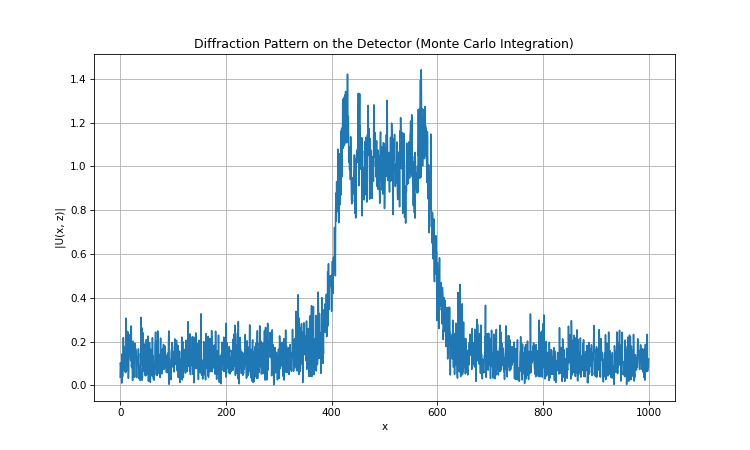

In [11]:
import numpy as np
from scipy.special import hankel1
import matplotlib.pyplot as plt

def monte_carlo_integration(U, x, z, s_min, s_max, num_samples, k):
    # Sample points within the aperture range [s_min, s_max]
    s_samples = np.random.uniform(s_min, s_max, num_samples)
    
    # Evaluate the integrand at the sampled points
    r = np.sqrt((x - s_samples)**2 + z**2)
    
    # Avoid division by zero or extremely small values of r
    r[r == 0] = 1e-10
    
    h = (1j * k * z / (2 * r)) * hankel1(1, k * r)
    integrand_samples = U(s_samples) * h
    
    # Approximate the integral by averaging the contributions and scaling by the aperture width
    aperture_width = s_max - s_min
    integral_approximation = (aperture_width / num_samples) * np.sum(integrand_samples)
    
    # r_circ = 1.0
    # amplitude0 = (z / r[0]) * 1 / np.sqrt(r_circ)
    # intensity0 = amplitude0**2
    # dS0 = r_circ
    # dS1 = (z / r[0])
    # intensity1 = (intensity0 * (dS0 / (dS1)))  * (z / r[0]) * (1 / r[0])
    # amplitude1 = np.sqrt(intensity1)

    # # Calculate phase and amplitude factors
    # phase = np.exp(1j * r * ((2 * cp.pi) / wavelength))
    # complex_rays = amplitude1 * phase

    
    return integral_approximation

# Define the aperture field U(s, 0) as a square wave
def U_aperture(s):
    return np.where((s >= 400) & (s <= 600), 1, 0)

# Define the parameters
z = 1000  # Propagation distance
wavelength = 1.0  # Wavelength of the wave
k = 2 * np.pi / wavelength  # Wavenumber
s_min = 0  # Start of aperture interval
s_max = 1000  # End of aperture interval
num_samples = 10000  # Number of Monte Carlo samples

# Define the detector range and resolution
x_min = 0
x_max = 1000
num_x_points = 2000  # Number of points on the detector
x_values = np.linspace(x_min, x_max, num_x_points)

# Calculate U(x, z) for all x points on the detector using Monte Carlo integration
U_xz_values = np.array([monte_carlo_integration(U_aperture, x, z, s_min, s_max, num_samples, k) for x in x_values])

# Plot the diffraction pattern
plt.figure(figsize=(10, 6))
plt.plot(x_values, np.abs(U_xz_values))
plt.title("Diffraction Pattern on the Detector (Monte Carlo Integration)")
plt.xlabel("x")
plt.ylabel("|U(x, z)|")
plt.grid(True)
plt.show()
